# 01 – Exploratory Data Analysis

# Proyecto #2: EDA – Exploratory Data Analysis
**Curso:** Manejo de Paquetes de Software II  
**Dataset:** Store Sales – Time Series Forecasting (Kaggle)  
**Objetivo:** realizar un análisis exploratorio de datos (EDA) que permita conocer la estructura del dataset, su calidad, los patrones temporales de la demanda y la viabilidad de usarlo en etapas posteriores de pronóstico.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("../data/raw")
train = pd.read_csv(DATA_DIR / "train.csv")
stores = pd.read_csv(DATA_DIR / "stores.csv")
train.head(), stores.head(), train.shape, stores.shape


(   id        date  store_nbr      family  sales  onpromotion
 0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1  2013-01-01          1   BABY CARE    0.0            0
 2   2  2013-01-01          1      BEAUTY    0.0            0
 3   3  2013-01-01          1   BEVERAGES    0.0            0
 4   4  2013-01-01          1       BOOKS    0.0            0,
    store_nbr           city                           state type  cluster
 0          1          Quito                       Pichincha    D       13
 1          2          Quito                       Pichincha    D       13
 2          3          Quito                       Pichincha    D        8
 3          4          Quito                       Pichincha    D        9
 4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4,
 (3000888, 6),
 (54, 5))

In [10]:

import seaborn as sns


plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 4)

DATA_DIR = Path("../data/raw") 

train = pd.read_csv(DATA_DIR / "train.csv")
stores = pd.read_csv(DATA_DIR / "stores.csv")
holidays = pd.read_csv(DATA_DIR / "holidays_events.csv")
transactions = pd.read_csv(DATA_DIR / "transactions.csv")

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [11]:
print("Shape train:", train.shape)
print("Shape stores:", stores.shape)

train.info()


Shape train: (3000888, 6)
Shape stores: (54, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


- El archivo `train.csv` contiene el historial diario de ventas por **sucursal** (`store_nbr`) y por **familia de producto** (`family`).
- Hay más de 5 sucursales: `train['store_nbr'].nunique()`  
- Hay más de 10 productos/familias: `train['family'].nunique()`  
- La variable objetivo para forecasting es `sales`.


In [12]:
num_stores = train['store_nbr'].nunique()
num_families = train['family'].nunique()
num_stores, num_families


(54, 33)

El dataset cumple con el requisito del proyecto:
- Sucursales: {{num_stores}} (≥ 5)
- Productos / familias: {{num_families}} (≥ 10)
- Tiene historial diario de ventas.


In [13]:
# convertir fecha
train['date'] = pd.to_datetime(train['date'])

# ordenar
train = train.sort_values('date')

# merge con info de tienda
df = train.merge(stores, on='store_nbr', how='left')

df.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2
3,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2


In [ ]:
#Verificación de nulos
df.isna().sum().sort_values(ascending=False)


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

In [15]:
# ventas globales
df['sales'].describe()


count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

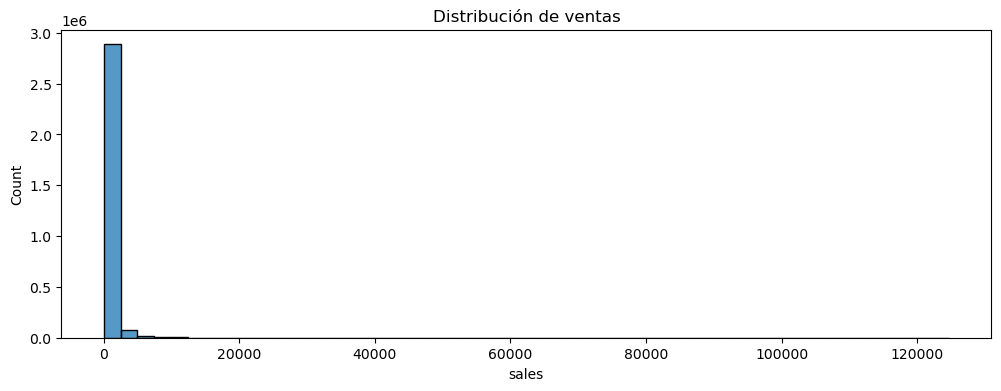

In [16]:
fig, ax = plt.subplots()
sns.histplot(df['sales'], bins=50, ax=ax)
ax.set_title("Distribución de ventas");


Se observa una fuerte concentración de ventas en valores bajos y una cola larga hacia la derecha, por lo que la variable `sales` es asimétrica positiva.


In [3]:

# Tipos y rango temporal
train['date'] = pd.to_datetime(train['date'])
print(train.dtypes)
print('Rango:', train['date'].min(), '->', train['date'].max())


id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object
Rango: 2013-01-01 00:00:00 -> 2017-08-15 00:00:00


In [4]:

# Faltantes y duplicados
missing = train.isna().mean().sort_values(ascending=False)
dups = train.duplicated().sum()
missing.head(10), dups


(id             0.0
 date           0.0
 store_nbr      0.0
 family         0.0
 sales          0.0
 onpromotion    0.0
 dtype: float64,
 np.int64(0))

In [17]:
#Variables derivadas - temporalidad
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dow'] = df['date'].dt.dayofweek  # 0=lunes
df['week'] = df['date'].dt.isocalendar().week.astype(int)


In [5]:

# Estadísticos y conteos
desc = train['sales'].describe()
num_stores = train['store_nbr'].nunique()
num_products = train['family'].nunique()
desc, num_stores, num_products


(count    3.000888e+06
 mean     3.577757e+02
 std      1.101998e+03
 min      0.000000e+00
 25%      0.000000e+00
 50%      1.100000e+01
 75%      1.958473e+02
 max      1.247170e+05
 Name: sales, dtype: float64,
 54,
 33)

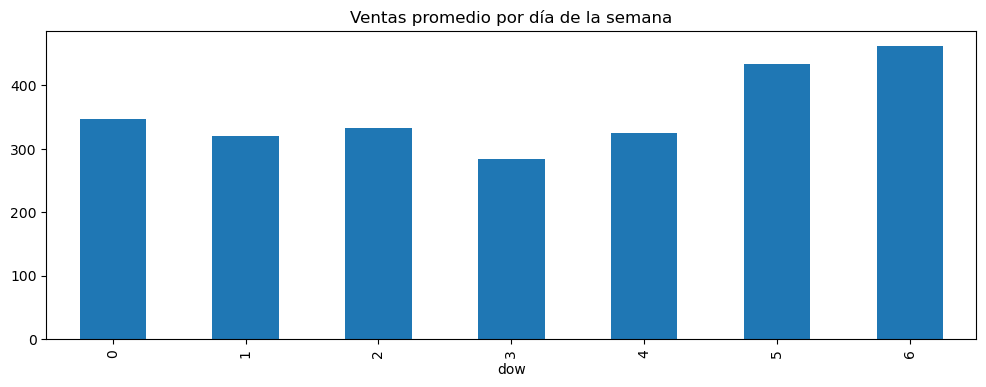

In [18]:
#Ventas por día de la semana
dow_sales = df.groupby('dow')['sales'].mean()
dow_sales.plot(kind='bar', title='Ventas promedio por día de la semana');


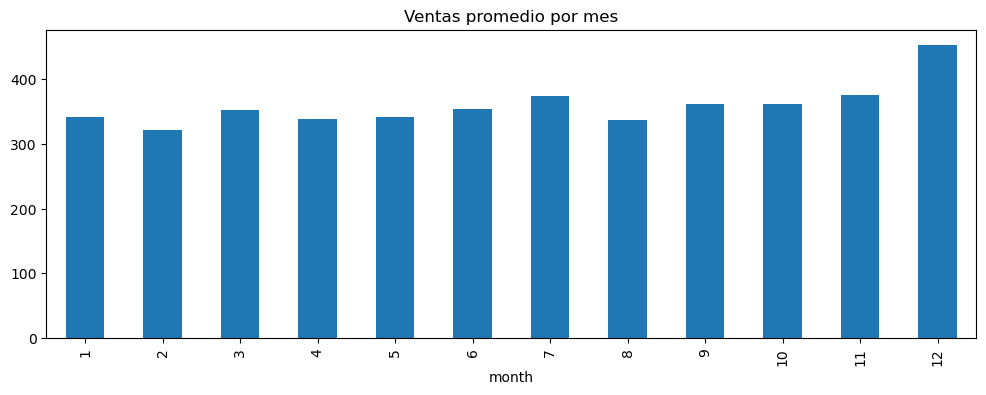

In [19]:
#Ventas por mes
month_sales = df.groupby('month')['sales'].mean()
month_sales.plot(kind='bar', title='Ventas promedio por mes');


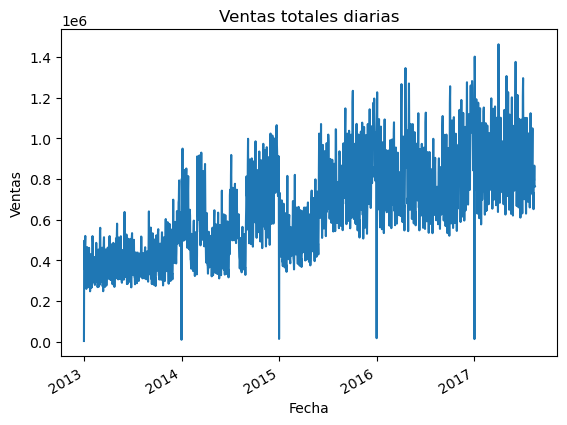

In [ ]:

# Ventas total
daily_total = train.groupby('date')['sales'].sum()
plt.figure()
daily_total.plot()
plt.title('Ventas totales diarias'); plt.xlabel('Fecha'); plt.ylabel('Ventas')
plt.show()


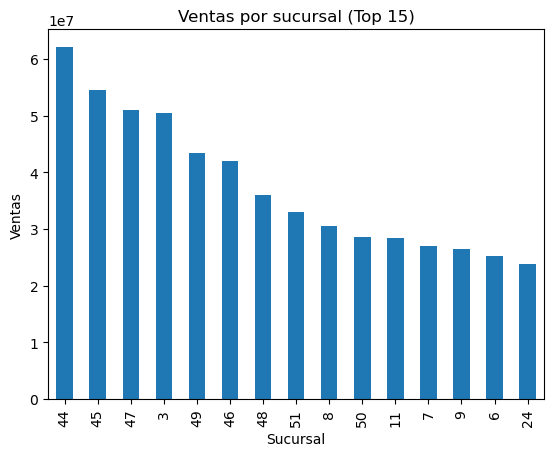

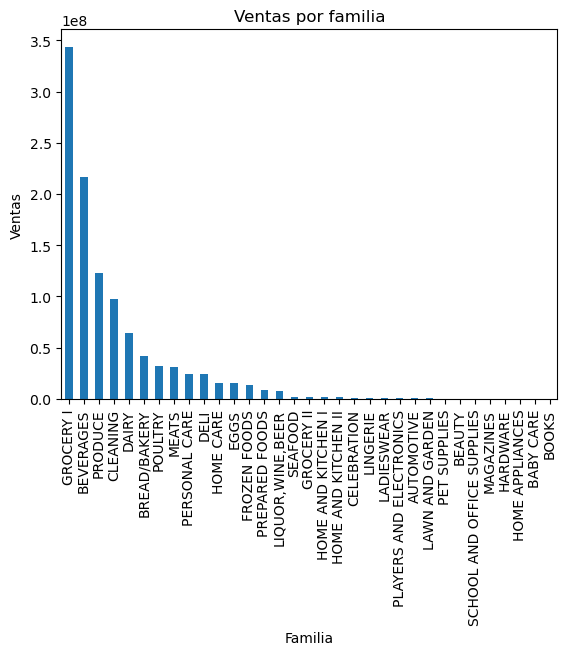

In [ ]:

# Ventas por sucursal y por familia
by_store = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(15)
plt.figure(); by_store.plot(kind='bar'); plt.title('Ventas por sucursal (Top 15)'); plt.xlabel('Sucursal'); plt.ylabel('Ventas'); plt.show()

by_family = train.groupby('family')['sales'].sum().sort_values(ascending=False)
plt.figure(); by_family.plot(kind='bar'); plt.title('Ventas por familia'); plt.xlabel('Familia'); plt.ylabel('Ventas'); plt.show()


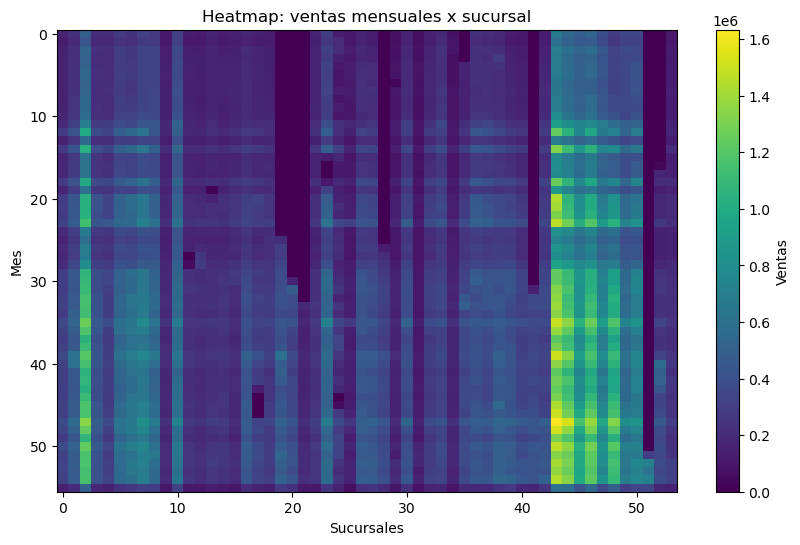

In [ ]:

# Heatmap mes x sucursal para ver el comportamiento de ventas entre sucursales y productos
train['year_month'] = train['date'].dt.to_period('M').dt.to_timestamp()
pivot = train.groupby(['store_nbr','year_month'])['sales'].sum().unstack(0).fillna(0)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(pivot.values, aspect='auto')
plt.title('Heatmap: ventas mensuales x sucursal'); plt.xlabel('Sucursales'); plt.ylabel('Mes')
plt.colorbar(label='Ventas')
plt.show()


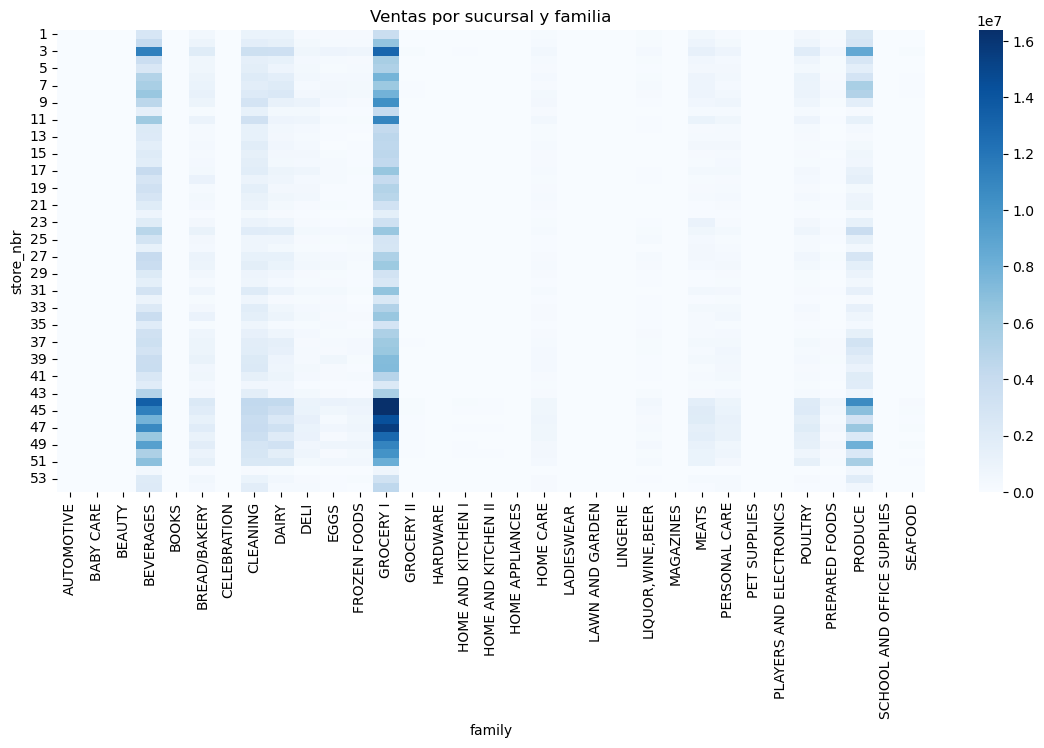

In [21]:
pivot = df.pivot_table(
    index='store_nbr',
    columns='family',
    values='sales',
    aggfunc='sum'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='Blues')
plt.title("Ventas por sucursal y familia")
plt.show()


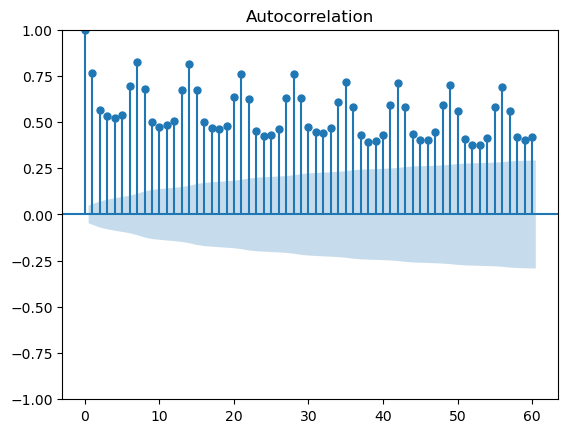

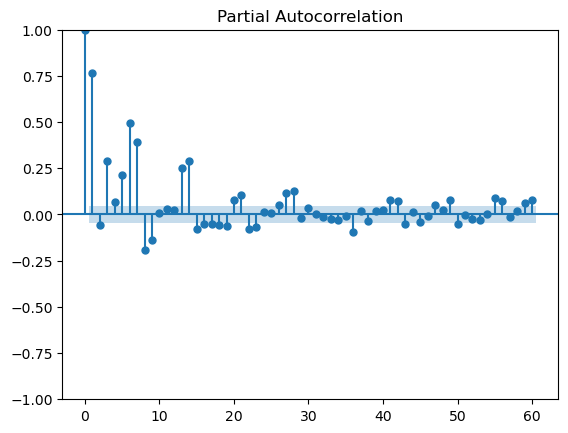

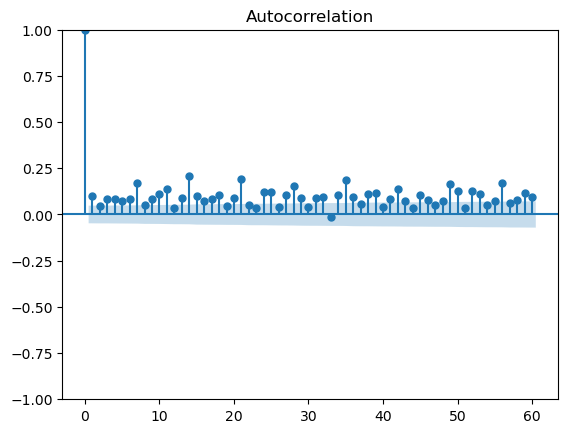

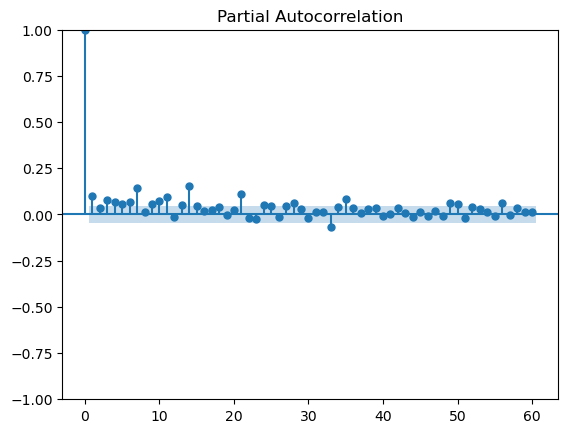

In [9]:

# ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
series = daily_total
plot_acf(series, lags=60); plt.show()
plot_pacf(series, lags=60, method='ywm'); plt.show()

store_id = 1
family_name = train['family'].iloc[0]
series_sf = train[(train['store_nbr']==store_id) & (train['family']==family_name)].sort_values('date').set_index('date')['sales'].asfreq('D').fillna(0)
plot_acf(series_sf, lags=60); plt.show()
plot_pacf(series_sf, lags=60, method='ywm'); plt.show()


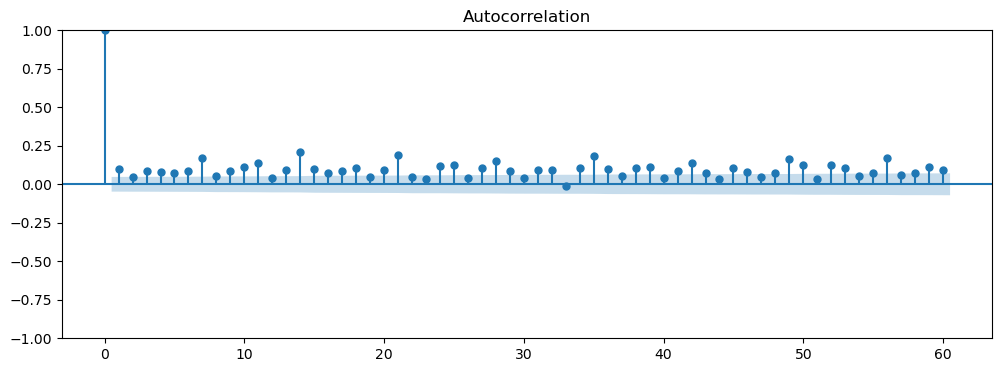

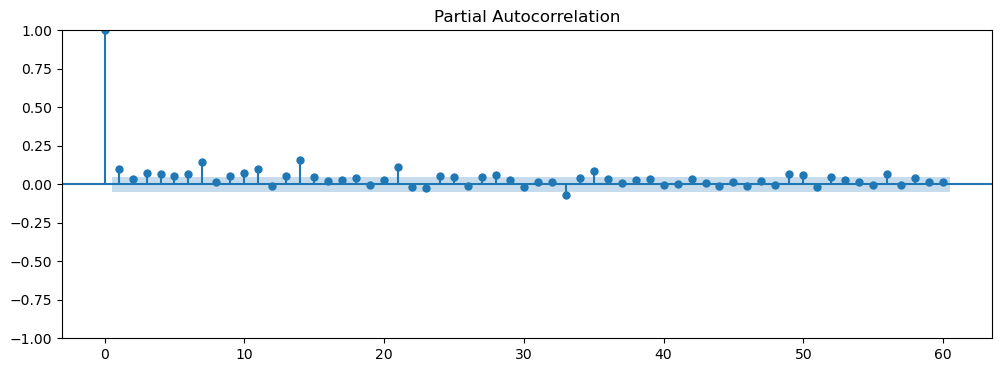

In [20]:
store_id = 1
family_name = df['family'].iloc[0]

series_sf = (
    df[(df['store_nbr'] == store_id) & (df['family'] == family_name)]
      .sort_values('date')
      .set_index('date')['sales']
      .asfreq('D')
      .fillna(0)
)

plot_acf(series_sf, lags=60)
plt.show()

plot_pacf(series_sf, lags=60, method='yw')
plt.show()




## Conclusiones

1. **El dataset cumple los requisitos del proyecto.** Se identificaron más de 5 sucursales (`store_nbr`) y más de 10 familias de productos (`family`), por lo que es posible construir modelos de pronóstico por tienda y por producto.
2. **La frecuencia de los datos es diaria**, con un rango de fechas continuo. Esto es adecuado para modelos de forecasting basados en series de tiempo.
3. **Las ventas presentan estacionalidad semanal y mensual.** El análisis por `day of week` mostró que algunos días tienen mayor demanda, lo cual deberá ser modelado.
4. **Existen grandes diferencias entre sucursales y familias**, por lo que no es recomendable un único modelo global sin variables de tienda/producto.
5. **El análisis de ACF y PACF** mostró autocorrelación significativa en varios rezagos, lo cual justifica el uso de modelos ARIMA/SARIMA o modelos basados en ventana temporal para la siguiente etapa del proyecto.
6. **El dataset puede enriquecerse** con información de feriados (`holidays_events.csv`) y transacciones (`transactions.csv`) para mejorar la capacidad predictiva.


Declaración de cumplimiento:

- Dataset seleccionado: Store Sales – Time Series Forecasting (Kaggle).
- Contiene registros históricos de ventas organizados por sucursal (`store_nbr`) y por producto/familia (`family`).
- Contiene más de 5 sucursales y más de 10 productos.
- La frecuencia es diaria.
- Permite analizar patrones de demanda y desarrollar modelos predictivos basados en series de tiempo.

Por lo anterior, el dataset cumple con todos los requisitos establecidos en el Proyecto #1 y se utilizó para el Proyecto #2 (EDA).
